# Integrated Gradient (IG)

Integrated gradient aims to explain the relationship between a model's predictions in terms of its features. It has many use cases including understanding feature importances, identifying data skew, and debugging model performance. 

IG has become a popular interpretability technique due to its broad applicability to any differential model (e.g. images, text, structured data, etc.), ease of implementation, theoretical justifications, and computational efficiency relative to alternative approaches that allows it to scale to large networks and feature spaces such as images.


## Import Libraries

In [106]:
import time
import math
import sys
import imageio
import glob
import IPython
from IPython import display
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_probability as tfp
import matplotlib.pylab as plt
from scipy.ndimage import gaussian_filter
print(tf.__version__)

2.3.0


## Import Pretrained Image Classifier from TF-Hub

IG can be applied to any neural network. To mirror the paper's implementation, we will use a pre-trained version of Inception V1 from Tensorflow Hub.

In [2]:
inception_v1_url = "https://tfhub.dev/google/imagenet/inception_v1/classification/4"

inception_v1_classifier = tf.keras.Sequential([
      hub.KerasLayer(name='inception_v1', 
                    handle=inception_v1_url, 
                    trainable=False),
])
inception_v1_classifier.build([None, 224, 224, 3])
inception_v1_classifier.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v1 (KerasLayer)    (None, 1001)              6633209   
Total params: 6,633,209
Trainable params: 0
Non-trainable params: 6,633,209
_________________________________________________________________


From the TF Hub module page, one need to keep in mind the following about Inception V1 for image classification:

**Inputs:** The expected input shape for the model is (None, 224, 244, 3,). This is a dense 4D tensor of dtype float32 and shape (batch_size, height, width, RGB channels) whose elements are RGB color values of pixels normalized to the range [0, 1]. The first element is None to indicate that the model can take any integer batch size.

**Outputs:** A tf.Tensor of logits in the shape of (n_images, 1001). Each row represents the model's predicted score for each of ImageNet's 1,001 classes. To covert the model's logit output to predicted probabilities across all classes, tf.nn.softmax(predictions, axis=-1) is used to quantify the model's uncertainty as well as explore similar predicted classes for debugging.

In [3]:
def load_imagenet_labels(file_path):
  """
  Read the text file
  Args:
    file_path (str): A URL download path.
  Returns:
    imagenet_label_array (numpy.ndarray): Array of strings with shape (1001,).
  """

  labels_file = tf.keras.utils.get_file('ImageNetLabels.txt', file_path)
  with open(labels_file) as reader:
    f = reader.read()
    labels = f.splitlines()
  return np.array(labels)

In [4]:
imagenet_labels = load_imagenet_labels('https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')

## Load and preprocess images with tf.image

In [5]:
def make_dataset(filepath):
    raw_dataset = tf.data.TFRecordDataset(filepath)
    
    image_feature_description = {
        'image/height': tf.io.FixedLenFeature([], tf.int64),
        'image/width': tf.io.FixedLenFeature([], tf.int64),
        'image/format': tf.io.FixedLenFeature([], tf.string),
        'image/encoded': tf.io.FixedLenFeature([], tf.string),
    }
    
    def preprocess_image(encoded_image):
        image = tf.image.decode_jpeg(encoded_image, channels=3)
        
        # resize to 286x286
        image = tf.image.resize(image, [286, 286], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

        image = tf.image.convert_image_dtype(image, tf.float32)
        image = tf.image.resize(image, (224, 224), preserve_aspect_ratio=True)
        image = tf.image.resize_with_pad(image, target_height=224, target_width=224)

        return image
    
    def parse_image_function(example_proto):
        # Parse the input tf.Example proto using the dictionary above.
        features = tf.io.parse_single_example(example_proto, image_feature_description)
        encoded_image = features['image/encoded']
        image = preprocess_image(encoded_image)
        return image
    
    parsed_image_dataset = raw_dataset.map(parse_image_function)
    return parsed_image_dataset

In [6]:
def read_image(file_name, preserve_aspect_ratio=True):
  """
  This function downloads and standardizes input JPEG images for the 
    inception_v1 model. Its applies the following processing:
    - Reads JPG file.
    - Decodes JPG file into colored image.
    - Converts data type to standard tf.float32.
    - Resizes image to expected Inception V1 input dimension of
      (224, 224, 3) with preserved aspect ratio. E.g. don't stretch image.
    - Pad image to (224, 224, 3) shape with black pixels.
  Args:
    file_name(str): Direct URL path to the JPG image.a
  Returns:
    image(Tensor): A Tensor of floats with shape (224, 224, 3).
    label(str): A text label for display above the image.
  """
  image = tf.io.read_file(file_name)
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.convert_image_dtype(image, tf.float32)
  image = tf.image.resize(image, (224, 224), preserve_aspect_ratio=preserve_aspect_ratio)
  image = tf.image.resize_with_pad(image, target_height=224, target_width=224)
  return image

In [7]:
# img_name_url {image_name: origin_url}
img_name_url = {
    'Fireboat': 'https://storage.googleapis.com/applied-dl/temp/San_Francisco_fireboat_showing_off.jpg',
    'School Bus': 'https://storage.googleapis.com/applied-dl/temp/Thomas_School_Bus_Bus.jpg',
    'Giant Panda': 'https://storage.googleapis.com/applied-dl/temp/Giant_Panda_2.jpeg',
    'Black Beetle': 'https://storage.googleapis.com/applied-dl/temp/Lucanus.jpeg',
    'Golden Retriever': 'https://storage.googleapis.com/applied-dl/temp/Golden_retriever.jpg',
    'Yellow Labrador Retriever': 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg',
}

In [8]:
img_paths = {name: tf.keras.utils.get_file(name, url) for (name, url) in img_name_url.items()}
img_tensors = {name: read_image(img_path) for (name, img_path) in img_paths.items()}

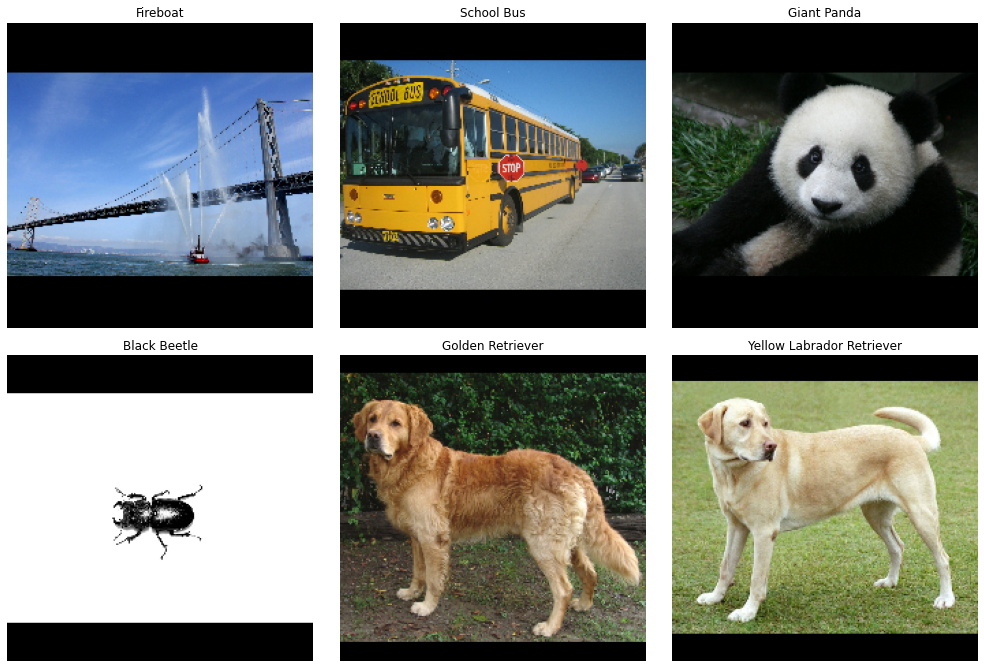

In [9]:
plt.figure(figsize=(14,14))
for n, (name, img_tensor) in enumerate(img_tensors.items()):
  ax = plt.subplot(3,3,n+1)
  ax.imshow(img_tensor)
  ax.set_title(name)
  ax.axis('off')
plt.tight_layout()

## Applying Integrated Gradients

IG is an elegant and simple idea to explain model's predictions in realtion to its input. The basic intuition is to measure a feature's importance to model by incrementally increasing a feeature's intesity between its baseline and its input value, compute the change between model's predictions with respect to the original feature at each step, and average these incremental changes together. 

### Step 1: Identify model input and output tensors

IG works with any differential model regardless of its implementation. As such one can pass any input example tensor to a model to generate an output prediction tensor. 

Following is a utility function to retrieve the top k predicted labels and probabilities.

In [10]:
# stack images into a batch for processing.
image_titles = tf.convert_to_tensor(list(img_tensors.keys()))
image_batch = tf.convert_to_tensor(list(img_tensors.values()))
image_batch.shape

TensorShape([6, 224, 224, 3])

In [11]:
def top_k_predictions(model, img, label_vocab, top_k=3):
  """
  Args:
    model (tf.keras.Model): Trained Keras model.
    img(tf.Tensor): A 4D tensor of floats with the shape  (img_n, img_height, img_width, 3).
    label_vocab (numpy.ndarray): An array of strings with shape (1001,).
    top_k (int): Number of results to return.
  Returns:
    k_predictions_idx(tf.Tensor): A tf.Tensor [n_images, top_k] of tf.int32 prediction indicies.
    k_predictions_proba(tf.Tensor): A tf.Tensor [n_images, top_k] of tf.float32 prediction probabilities.
    k_predictions_label(tf.Tensor): A tf.Tensor [n_images, top_k] of tf.string prediction labels.   
  """
  if len(img.shape)==3:
    img = tf.expand_dims(img, 0)
    
  # Model's Logits Output (unnormalized scores)
  predictions = model(img)
  
  # Convert the logits to predicted probabilities across all the classes
  predicted_probs = tf.nn.softmax(predictions, axis=-1)

  # Filter top k prediction probabilities and indicies
  k_predictions_probs, k_predictions_idxs = tf.math.top_k(input=predicted_probs, k=top_k)

  # Lookup top k prediction labels in labels array
  k_predictions_labels = tf.convert_to_tensor(label_vocab[k_predictions_idxs.numpy()], dtype=tf.string)

  if img.shape[0]==1:
    return tf.squeeze(k_predictions_idxs), tf.squeeze(k_predictions_labels), tf.squeeze(k_predictions_probs)
  else:
    return k_predictions_idxs, k_predictions_labels, k_predictions_probs

In [12]:
def plot_img_predictions(model, img, img_titles, label_vocab, top_k=3):
  """
  Plot images with top_k predictions.
  Args:
    model (tf.keras.Model): Trained Keras model.
    img (Tensor): A 4D Tensor of floats with the shape (img_n, img_height, img_width, 3).
    img_titles (Tensor): A Tensor of strings with the shape (img_n, img_height, img_width, 3).
    label_vocab (numpy.ndarray): An array of strings with shape (1001,).
    top_k (int): Number of results to return.
  
  Returns:
    fig(matplotlib.pyplot.figure): fig object to utilize for displaying, saving plots.
  """

  pred_idx, pred_label, pred_proba = top_k_predictions(model=model, 
                                                       img=img, 
                                                       label_vocab=label_vocab, 
                                                       top_k=top_k)
  
  img_arr = img.numpy()
  title_arr = img_titles.numpy()
  pred_idx_arr = pred_idx.numpy()
  pred_label_arr = pred_label.numpy()
  pred_proba_arr = pred_proba.numpy()
  n_rows = img_arr.shape[0]

  # Preserve image height by converting pixels to inches based on dpi.
  size = n_rows * (224 // 48)
  
  fig, axs = plt.subplots(nrows=img_arr.shape[0], ncols=1, figsize=(size, size), squeeze=False)
  for idx, image in enumerate(img_arr):
    axs[idx, 0].imshow(image)
    axs[idx, 0].set_title(title_arr[idx].decode('utf-8'), fontweight='bold')
    axs[idx, 0].axis('off')
    for k in range(top_k):
      k_idx = pred_idx_arr[idx][k]
      k_label = pred_label_arr[idx][k].decode('utf-8')
      k_proba = pred_proba_arr[idx][k]
      if k==0:
        s = 'Prediction {:}: ({:}-{:}) Score: {:.1%}'.format(k+1, k_idx, k_label, k_proba)
        axs[idx, 0].text(244 + size, 102+(k*40), s, fontsize=12, fontweight='bold')
      else:
        s = 'Prediction {:}: ({:}-{:}) Score: {:.1%}'.format(k+1, k_idx, k_label, k_proba)
        axs[idx, 0].text(244 + size, 102+(k*20), s, fontsize=12)
  plt.tight_layout()      

  return fig

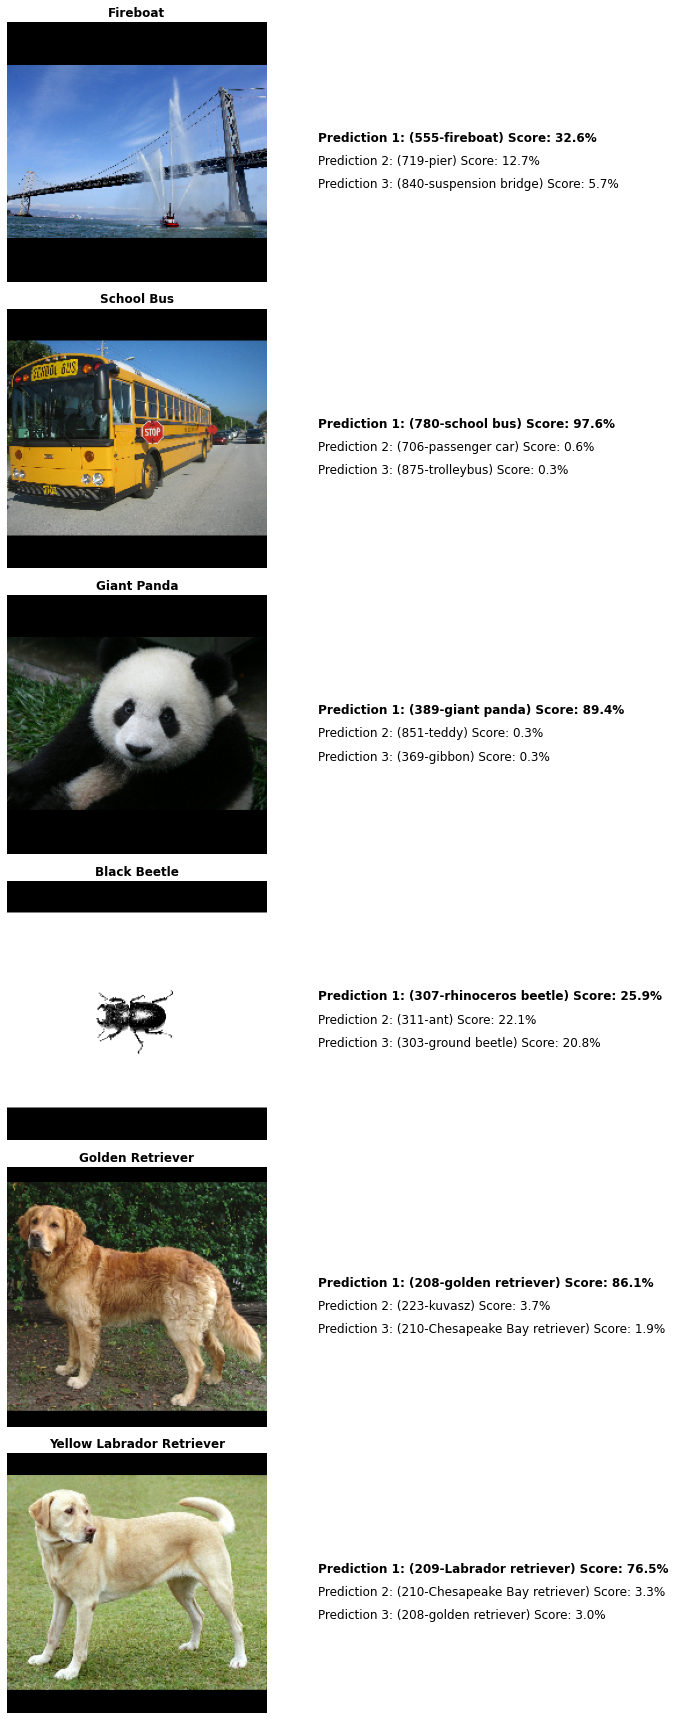

In [13]:
_ = plot_img_predictions(
      model=inception_v1_classifier,
      img=image_batch,
      img_titles=image_titles,
      label_vocab=imagenet_labels, 
      top_k=3
    )

### Calculate Integrated Gradients

Inception V1 is a learned function that describes a mapping between input feature space, image pixel values, and an output space defined by ImageNet class probability values between 0 and 1. 

Early interpretability method for neural networks assigned feature importance scores using gradients, which tell you which pixel have steepest local relative to model's prediction function at a given point along wth model's prediction function. However, gradients only describe local changes in model's prediction function with respect to pixel values and do not fully describe entire model prediction function. As model fully learns the relationship between the range of an inidvidual pixel and the correct ImageNet Class, the gradient for this pixel with saturate, meaning become increasingly small and even go to zero. 

In [14]:
def f(x):
  """
  A simplified model function.
  """
  return tf.where(x < 0.8, x, 0.8)

def interpolated_path(x):
  """A straight line path."""
  return tf.zeros_like(x)

x = tf.linspace(start=0.0, stop=1.0, num=6)
y = f(x)

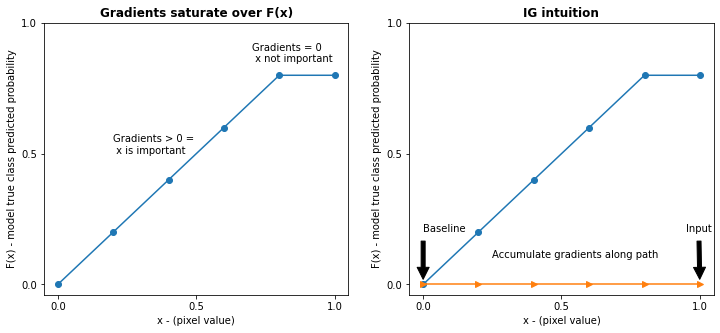

In [15]:
fig = plt.figure(figsize=(12, 5))
ax0 = fig.add_subplot(121)
ax0.plot(x, f(x), marker='o')
ax0.set_title('Gradients saturate over F(x)', fontweight='bold')
ax0.text(0.2, 0.5, 'Gradients > 0 = \n x is important')
ax0.text(0.7, 0.85, 'Gradients = 0 \n x not important')
ax0.set_yticks(tf.range(0, 1.5, 0.5))
ax0.set_xticks(tf.range(0, 1.5, 0.5))
ax0.set_ylabel('F(x) - model true class predicted probability')
ax0.set_xlabel('x - (pixel value)')

ax1 = fig.add_subplot(122)
ax1.plot(x, f(x), marker='o')
ax1.plot(x, interpolated_path(x), marker='>')
ax1.set_title('IG intuition', fontweight='bold')
ax1.text(0.25, 0.1, 'Accumulate gradients along path')
ax1.set_ylabel('F(x) - model true class predicted probability')
ax1.set_xlabel('x - (pixel value)')
ax1.set_yticks(tf.range(0, 1.5, 0.5))
ax1.set_xticks(tf.range(0, 1.5, 0.5))
ax1.annotate('Baseline', xy=(0.0, 0.0), xytext=(0.0, 0.2),
             arrowprops=dict(facecolor='black', shrink=0.1))
ax1.annotate('Input', xy=(1.0, 0.0), xytext=(0.95, 0.2),
             arrowprops=dict(facecolor='black', shrink=0.1))
plt.show();

*   **left:** Model's gradients for pixel x are positive between 0.0 and 0.8 but go to 0.0 between 0.8 and 1.0. Pixel x clearly has a significant impact on pushing model towards 80% predicted probability on the true class. 
*   **right:** The intuition behind IG is to accumulate pixel x's local gradients and attribute its importance as a score for how much it adds or subtracts to model's overall output class probability. The IG can be break down and computed in 3 parts:
  1. interpolate small steps along a straight line in the feature space between 0 (a baseline) and 1(input pixel's value)
  2. compute gradients at each step between model's prediction with respect to each step.
  3. approximate the integral between baseline and input by accumulating these local gradients.    





## Step 2: Establish baseline to compare inputs against

Defining missingness or a starting point in feature spaces for comparison is at the core of machine learning interpretability methods. For IG, this concept is emcoded as baseline. 

A baseline is an input image used as a starting point for calculating feature importance. Intuitively one can think of the baseline's explanatory role as representing the impact of the absence of each pixel on model's prediction to contrast with its impact of each pixel on the model's prediction when present in the input image. 

When selecting a baseline for neural networks, the goal is to choose a baseline such as the prediction at the baseline is near zero to minimize aspects of the baseline impacting interpretation of the prediction attributions.

As a result, the choice of the baseline plays a central role in interpreting and visualizing pixel feature importances. 

In [16]:
def get_uniform_image(image, minval=0.0, maxval=1.0):
  return tf.random.uniform(shape=(224,224,3), minval=minval, maxval=maxval)

def get_blurred_image(image, sigma=40):
    if len(image.shape) == 4:
        blurred_images = [gaussian_filter(im, (sigma, sigma, 0)) for im in image]
        return tf.stack(blurred_images, axis=0)
    elif len(image.shape) == 3:
        return gaussian_filter(image, (sigma, sigma, 0))
    else:
        return gaussian_filter(image, sigma)

def get_gaussian_image(image, sigma, mean_image=None, minval=-1.0, maxval=1.0):
    if mean_image is None:
        mean_image = image
    gaussian_image = tf.random.normal(image.shape) * sigma + mean_image
    return tf.clip_by_value(gaussian_image, clip_value_min=minval, clip_value_max=maxval)

def get_max_distance_image(image, minval=0.0, maxval=1.0):
    meanval = (minval + maxval) * 0.5
    max_dist_im = np.full(image.shape, minval, dtype='float32')
    max_dist_im[image < meanval] = maxval
    return tf.constant(max_dist_im)

def baseline_method(image, method="Black", sigma=0.5, mean_image=None, minval=0.0, maxval=1.0):
  if method=="Black":
    return tf.zeros(shape=(224,224,3))
  elif method=="White":
    return tf.ones(shape=(224,224,3))
  elif method=="Uniform" or method=="Random":
    return get_uniform_image(image, minval=minval, maxval=maxval)
  elif method=="Gaussian":
    return get_gaussian_image(image, sigma=sigma, mean_image=mean_image, minval=minval, maxval=maxval)
  elif method=="Blur":
    return get_blurred_image(image, sigma=sigma)
  elif method=="Max Distance" or method=="Max_Distance":
    return get_max_distance_image(image, minval=minval, maxval=maxval)
  else:
    raise ValueError("In-valid method encountered")

def normalize(im_batch, _range=None, _domain=None):
    if len(im_batch.shape) == 2:
        axis = (0, 1)
    elif len(im_batch.shape) == 3:
        axis = (0, 1, 2)
    elif len(im_batch.shape) == 4:
        axis = (1, 2, 3)
    else:
        raise ValueError('im_batch must be of rank 2, 3 or 4')
    
    if _domain is not None:
        min_vals = _domain[0]
        max_vals = _domain[1]
    else:
        min_vals = np.amin(im_batch, axis=axis, keepdims=True)
        max_vals = np.amax(im_batch, axis=axis, keepdims=True)
    
    norm_batch = (im_batch - min_vals) / (max_vals - min_vals)
    
    if _range is not None:
        amin = _range[0]
        amax = _range[1]
        norm_batch = norm_batch * (amax - amin) + amin
    return norm_batch

def norm_clip(x, percentile=99.9):
    normalized = normalize(tf.squeeze(x))
    clipped = tf.clip_by_value(normalized, 
                      clip_value_min=tf.reduce_min(normalized), 
                      clip_value_max=tfp.stats.percentile(normalized, percentile))
    return clipped

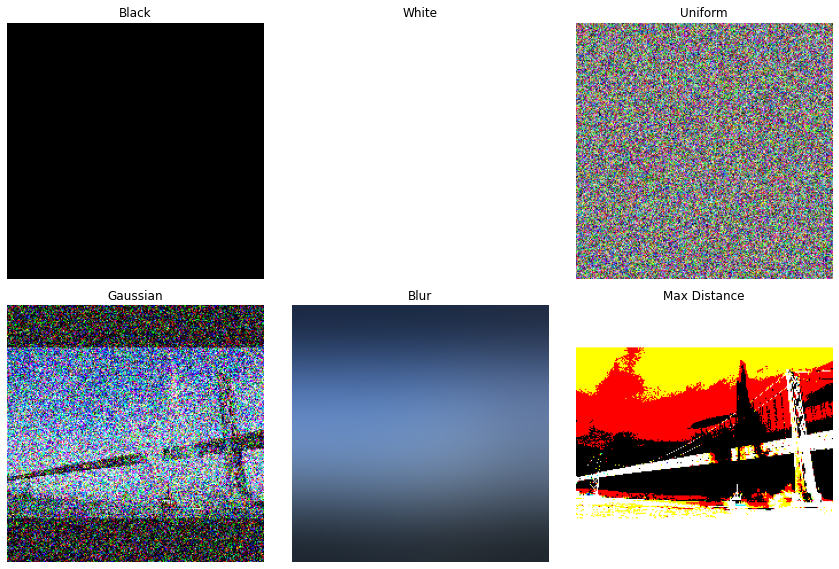

In [17]:
plt.figure(figsize=(12,8))
methods = ["Black", "White", "Uniform", "Gaussian", "Blur", "Max Distance"]
c = 1
for idx in methods:
  ax = plt.subplot(2, 3, c)
  ax.imshow(baseline_method(img_tensors["Fireboat"], method=idx, sigma=0.5 if idx!="Blur" else 40))
  ax.set_title(idx)
  ax.axis('off')
  c += 1
plt.tight_layout()

## Integrated Gradients (IG)

The formula for IG is as follows:
$$IG_i(x):=(x_i-x_i')\times\int_{\alpha=0}^{1}\frac{\partial F(x'+\alpha \times (x-x'))}{\partial x_i}d\alpha$$
where:\
$i=$ feature\
$x=$ input\
$x'=$ baseline\
$\alpha=$ interpolation constant to perturb features by

In practice, computing a definite integral is not always numerically possible and can be computationally costly, so compute the following numerical approximation:
$$IG_i^{approx}(x):=(x_i-x_i')\times \sum_{k=1}^m\frac{\partial F(x'+\frac{k}{m} \times (x-x'))}{\partial x_i}\times \frac{1}{m}$$

where:\
$i=$ feature (individual pixel)\
$x=$ input (image tensor)\
$x'=$ baseline (image tensor)\
$k=$ scaled feature perturbation constant\
$m=$ number of steps in the Riemann sum approximation of the integral\
$(x_i-x_i')=$ a term for the difference from the baseline. This is necessary to scale the integrated gradients and keep them in terms of the original image.

The path from the baseline image to the input image is in pixel space. Since with IG, we are integrating in a straight line (linear transfomration) this ends up being roughly equivalent to the integral term of the derivative of the interpolated image function with respect to $\alpha$ with enough steps. This integral sums each pixel's gradient times the change in the pixel along the path.  

### Interpolate Images

$$IG_i^{approx}(x):=(x_i-x_i')\times \sum_{k=1}^m\frac{\partial F(x'+\frac{k}{m} \times (x-x'))}{\partial x_i}\times \frac{1}{m}$$

First, generate a linear interpolation between the baseline and the original image. One can think of interpolated images as small steps in the feature space between baseline and input, represented by $\alpha$ in the original equation. 

In [18]:
alphas = tf.linspace(start=0.0, stop=1.0, num=51)

In [19]:
def interpolate_images(baseline, image, alphas):
  """
  Generate m interpolated inputs between baseline and input features.
  Args:
    baseline (Tensor): A 3D image tensor of floats with the shape (img_height, img_width, 3).
    input (Tensor): A 3D image tensor of floats with the shape (img_height, img_width, 3).
    alphas (Tensor): A 1D tensor of uniformly spaced floats with the shape (m_steps,).
  Returns:
    path_inputs (Tensor): A 4D tensor of floats with the shape (m_steps, img_height, img_width, 3).
  """

  # To make alphas compatible with model dimension [batch_size, height, width, channels]
  alphas_x = alphas[:, tf.newaxis, tf.newaxis, tf.newaxis]
  # Add batch dimension
  baseline_x = tf.expand_dims(baseline, axis=0)
  input_x = tf.expand_dims(image, axis=0)

  # (x-x')
  delta = input_x - baseline_x
  # x'+alpha*(x-x')
  path_images = baseline_x +  alphas_x * delta

  return path_images

In [78]:
image = img_tensors['Giant Panda']
baseline = baseline_method(image, method="Blur", sigma=20)
path_inputs = interpolate_images(
    baseline=baseline,
    image=image,
    alphas=alphas)

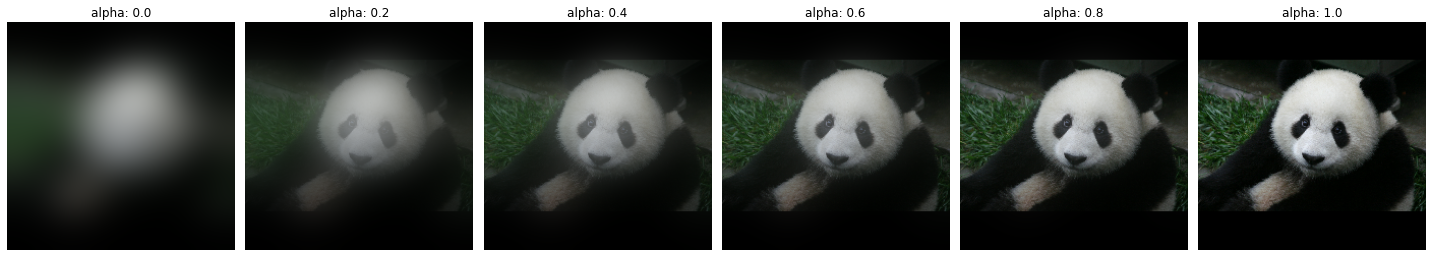

In [79]:
fig = plt.figure(figsize=(20, 20))

i = 0
for alpha, image in zip(alphas[0::10], path_inputs[0::10]):
  i += 1
  plt.subplot(1, len(alphas[0::10]), i)
  plt.title(f'alpha: {alpha:.1f}')
  plt.imshow(image)
  plt.axis('off')

plt.tight_layout();

### Compute Gradients

In the case of images, the gradients tells us which pixels have the strongest effect on the models predicted class probabilities. 
$$IG_i^{approx}:=(x_i-x_i')\times \sum_{k=1}^m\frac{\partial F(\text{interpolated images})}{\partial x_i} \times \frac{1}{m}$$

where\
$F() = $ model's prediction function\
$\frac{\partial F}{x_i}=$ gradient of model F's prediction function relative to each feature $x_i$ 

In Tensorflow, gradients are computed easily using tf.GradientTape


In [22]:
def compute_gradients(model, images, target_class_idx):
  """
  Compute gradients of model predicted probabilties with respect to inputs.
  Args:
    mode(tf.keras.Model): Trained Keras model.
    path_inputs(Tensor): A 4D tensor of floats with the shape (m_steps, img_height, img_width, 3).
    target_class_idx(Tensor): A 0D tensor of an int corresponding to the correct ImageNet target class index.
  Returns:
    gradients(Tensor): A 4D tensor of floats with the shape (m_steps, img_height, img_width, 3).
  """
  with tf.GradientTape() as tape:
    tape.watch(images)
    logits = model(images)
    probs = tf.nn.softmax(logits, axis=-1)[:, target_class_idx]
  return tape.gradient(probs, images)

Computing the gradient for each image along the interpolation path with respect to the correct output label. 

In [23]:
path_gradients = compute_gradients(
    model=inception_v1_classifier,
    images=path_inputs,
    target_class_idx=tf.constant(389))

In [24]:
print(path_gradients.shape)

(51, 224, 224, 3)


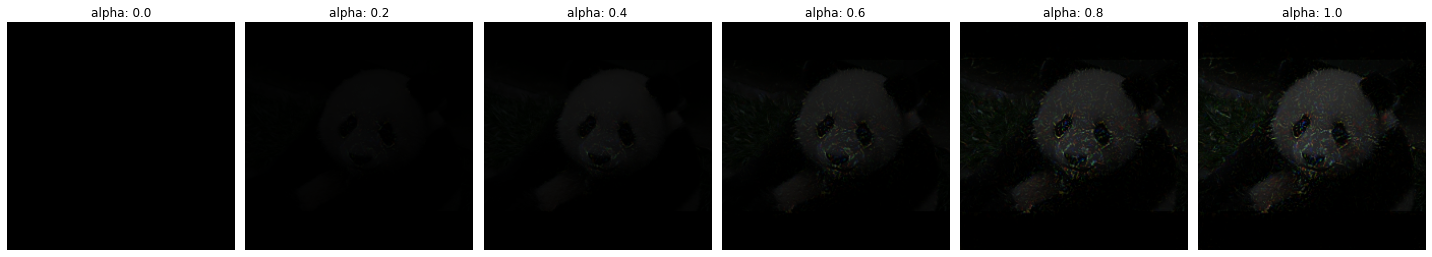

In [25]:
fig = plt.figure(figsize=(20, 20))

i = 0
for alpha, mask, image in zip(alphas[0::10], path_gradients[0::10], path_inputs[0::10]):
  i += 1
  plt.subplot(1, len(alphas[0::10]), i)
  plt.title(f'alpha: {alpha:.1f}')

  plt.imshow(tf.cast(255 * path_gradients[i], tf.uint8), cmap=plt.cm.inferno)
  plt.imshow(image, alpha=0.2)
  plt.axis('off')
plt.tight_layout()

## Visualizing gradient saturation

The gradients calculated above describe local changes to the model's predicted probability of "Fireboat" and can saturate.

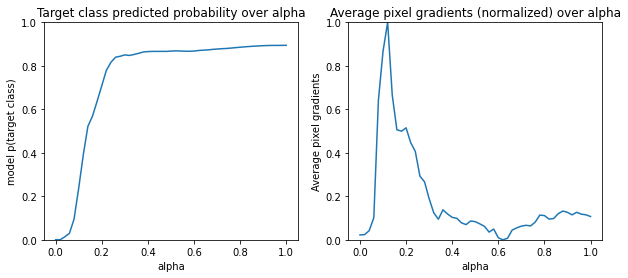

In [26]:
pred = inception_v1_classifier(path_inputs)
pred_proba = tf.nn.softmax(pred, axis=-1)[:, 389]

plt.figure(figsize=(10, 4))
ax1 = plt.subplot(1, 2, 1)
ax1.plot(alphas, pred_proba)
ax1.set_title('Target class predicted probability over alpha')
ax1.set_ylabel('model p(target class)')
ax1.set_xlabel('alpha')
ax1.set_ylim([0, 1])

ax2 = plt.subplot(1, 2, 2)
# Average across interpolation steps
average_grads = tf.reduce_mean(path_gradients, axis=[1, 2, 3])

# Normalize gradients to 0 to 1 scale. E.g. (x - min(x))/(max(x)-min(x))
average_grads_norm = (average_grads-tf.math.reduce_min(average_grads))/(tf.math.reduce_max(average_grads)-tf.reduce_min(average_grads))
ax2.plot(alphas, average_grads_norm)
ax2.set_title('Average pixel gradients (normalized) over alpha')
ax2.set_ylabel('Average pixel gradients')
ax2.set_xlabel('alpha')
ax2.set_ylim([0, 1]);

*   **left:** The plot shows how model's confidence in the "Panda" class varies across alphas. Notice how the gradients largely saturates between 0.3 and 1.0 before settling at the final "Panda" predicted probability of about 90%.
*   **right:** The right plot shows the average gradients magnitudes over alphas more directly. One can also see the peak moment where the model learns the target "Giant Panda" but also that the gradient magnitudes quickly minimizes toward 0 and even become discontinuous briefly after 0.6. In practice, this can result in gradient attributions to miss important features that differ between input and baseline and to focus on irrelevant features.

**The beauty of IG is that it solves the problem of discontinuous gradient feature importances by taking small steps in the feature space to compute local gradients between predictions and inputs across the feature space and then averages these gradients together to produce IG feature attributions.**



### Accumulate Gradients (Integral Approximation)

There are many different ways to compute the numeric approximation of an integral for IG with different tradeoffs in accuracy and convergence across varying functions. A popular class of methods is called Riemann sums. 

The code below shows the visual geometric interpretation for Left, Right, Midpoint, and Trapezoidal Reimann Sums:

In [27]:
def plot_riemann_sums(fn, start_val, end_val, m_steps=10):
  """
  Plot Riemann Sum integral approximations for single variable functions.
  Args:
    fn (function): Any single variable function.
    start_val (int): Minimum function value constraint.
    end_val (int): Maximum function value constraint.
    m_steps (int): Linear interpolation steps for approximation.
  Returns:
    fig (matplotlib.pyplot.figure): fig object to utilize for displaying, saving plots.
  """

  # fn plot args
  x = tf.linspace(start_val, end_val, m_steps**2+1)
  y = fn(x)

  fig = plt.figure(figsize=(16,4))

  # Left Riemann Sum
  lr_ax = plt.subplot(1,4,1)
  lr_ax.plot(x, y)
  lr_x = tf.linspace(0.0, 1.0 - (1 / m_steps), m_steps+1)
  lr_left = lr_x[:-1]
  lr_right = fn(lr_x[:-1])
  lr_ax.plot(lr_left,lr_right,'b.',markersize=10)
  lr_ax.bar(lr_left,lr_right,width=(end_val-start_val)/m_steps,alpha=0.2,align='edge',edgecolor='b')
  lr_ax.set_title('Left Riemann Sum \n m_steps = {}'.format(m_steps))
  lr_ax.set_xlabel('alpha')

  # Right Riemann Sum
  rr_ax = plt.subplot(1,4,2)
  rr_ax.plot(x, y)
  rr_x = tf.linspace(1.0 / m_steps, 1.0, m_steps+1)
  rr_left = rr_x[1:]
  rr_right = fn(rr_x[1:])
  rr_ax.plot(rr_left,rr_right,'b.',markersize=10)
  rr_ax.bar(rr_left,rr_right,width=-(end_val-start_val)/m_steps,alpha=0.2,align='edge',edgecolor='b')
  rr_ax.set_title('Right Riemann Sum \n m_steps = {}'.format(m_steps))
  rr_ax.set_xlabel('alpha')

  # Midpoint Riemann Sum
  mr_ax = plt.subplot(1,4,3)
  mr_ax.plot(x, y)
  mr_x = tf.linspace(1.0 / (2.0 * m_steps), 1.0 - 1.0 / m_steps, m_steps+1)
  mr_left = (mr_x[:-1] + mr_x[1:])/2
  mr_right = fn(mr_left)
  mr_ax.plot(mr_left,mr_right,'b.',markersize=10)
  mr_ax.bar(mr_left,mr_right,width=(end_val-start_val)/m_steps,alpha=0.2, edgecolor='b')
  mr_ax.set_title('Midpoint Riemann Sum \n m_steps = {}'.format(m_steps))
  mr_ax.set_xlabel('alpha')

  # Trapezoidal Riemann Sum
  tp_ax = plt.subplot(1,4,4)
  tp_ax.plot(x, y)
  tp_x = tf.linspace(0.0, 1.0, m_steps+1)
  tp_y = fn(tp_x)
  for i in range(m_steps):
    xs = [tp_x[i], tp_x[i], tp_x[i+1], tp_x[i+1]]
    ys = [0, tp_y[i], tp_y[i+1], 0]
    tp_ax.plot(tp_x,tp_y,'b.',markersize=10)
    tp_ax.fill_between(xs,ys, color='C0',edgecolor='blue', alpha=0.2)
  tp_ax.set_title('Trapezoidal Riemann Sum \n m_steps = {}'.format(m_steps))
  tp_ax.set_xlabel('alpha')

  return fig

A feature's gradient will vary in magnitude over the interpolated images between the baseline and input. It is important to choose a method to best approximate the area of difference, also known as the integral between the baseline and input in the feature space. Let's consider the down facing parabola varying between 0 and 1 as a proxy for how a feature gradient could vary in magnitude and sign over different alphas. To implement IG, we care about approximation accuracy and covergence. Left, Right, and Midnight Riemann Sums utilize rectangles to approximate areas under the function while Trapezoidal Riemann Sums utilize trapezoids. 

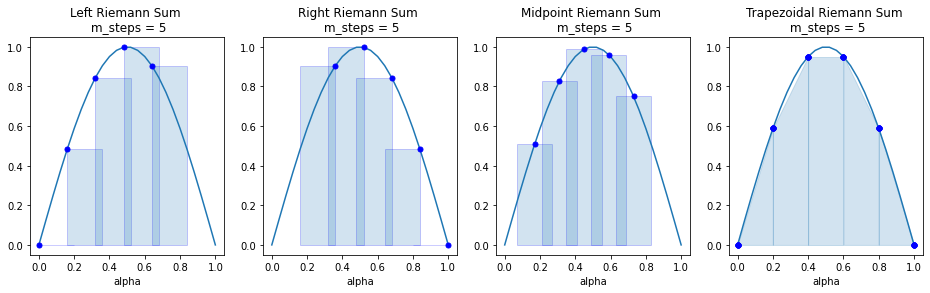

In [28]:
_ = plot_riemann_sums(lambda x: tf.math.sin(x*math.pi), 0.0, 1.0, m_steps=5)

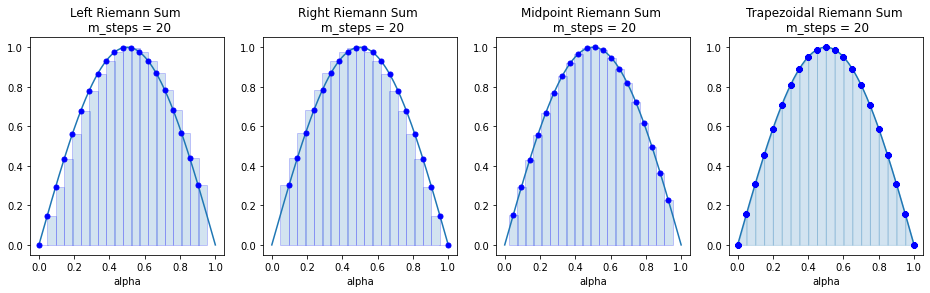

In [29]:
_ = plot_riemann_sums(lambda x: tf.math.sin(x*math.pi), 0.0, 1.0, m_steps=20)

**Which integral approximation method to choose for IG?**

From the Riemann sum plots above one can see that the Trapezoidal Riemann Sum clearly provides a more accurate approximation and coverges more quickly over m_steps than the alternatives e.g. less white space under function not covered by shapes. Consequently, it is presented as the default method in the code below. 

The $\alpha$ constant is introduced in the Generate interpolated path inputs section for varying the intensity of the interpolated images between the baseline and input image. In the generate_alphas function below, one can see that $\alpha$ changes with each approximation method to reflect different start and end points and underlying geometric shapes of either a rectangle or trapezoid used to approximate the integral area. It takes a method parameter and a m_steps parameter that controls the accuracy of the integral approximation.

In [30]:
def generate_alphas(m_steps=tf.constant(50), 
                    method='riemann_trapezoidal'):
  """
  Args:
    m_steps (Tensor): A 0D tensor of an int corresponding to the number of linear
                     interpolation steps for computing an approximate integral.
    method (str): A string representing the integral approximation method.
                  1- riemann_trapezoidal(default)
                  2- riemann_left
                  3- riemann_midpoint
                  4- riemann_right
  Returns:
    alphas (Tensor): A 1D tensor of uniformly spaced floats with the shape (m_steps,).
  """

  if method == 'riemann_trapezoidal':
    alphas = tf.linspace(0.0, 1.0, m_steps)
  elif method == 'riemann_left':
    alphas = tf.linspace(0.0, 1.0 - (1 / m_steps), m_steps)
  elif method == 'riemann_midpoint':
    alphas = tf.linspace(1.0 / (2.0 * m_steps), 1.0 - 1.0 / m_steps, m_steps)    
  elif method == 'riemann_right':    
    alphas = tf.linspace(1.0 / m_steps, 1.0, m_steps)
  else:
    raise AssertionError("Provided Riemann approximation method is not valid.")

  return alphas

$$IG_i^{approx}:=(x_i-x_i')\times \sum_{k=1}^m\frac{\partial F(\text{interpolated images})}{\partial x_i} \times \frac{1}{m}$$

We are summing over m gradients and dividing by m steps. This can be implemented as an average of the local gradients of m interpolated prediction and input images.

In [31]:
def integral_approximation(gradients, 
                           method='riemann_trapezoidal'):
  """
  Compute numerical approximation of integral from gradients.

  Args:
    gradients(Tensor): A 4D tensor of floats with the shape (m_steps, img_height, img_width, 3).
    method(str): A string representing the integral approximation method. 
                - riemann_trapezoidal(default)
                - riemann_left
                - riemann_midpoint
                - riemann_right 
  Returns:
    integrated_gradients(Tensor): A 3D tensor of floats with the shape (img_height, img_width, 3).
  """
  if method == 'riemann_trapezoidal':  
    grads = (gradients[:-1] + gradients[1:]) / tf.constant(2.0)
  elif method == 'riemann_left':
    grads = gradients[:-1]
  elif method == 'riemann_midpoint':
    grads = (gradients[:-1] + gradients[1:]) / tf.constant(2.0)    
  elif method == 'riemann_right':    
    grads = gradients[1:]
  else:
    raise AssertionError("Provided Riemann approximation method is not valid.")

  # Average integration approximation.
  integrated_gradients = tf.math.reduce_mean(grads, axis=0)

  return integrated_gradients

The integral_approximation function takes the gradients of the predicted probability of the target class with respect to the interpolated images between the baseline and the original image.

In [32]:
ig = integral_approximation(gradients=path_gradients)
print(ig.shape)

(224, 224, 3)


## Putting it all together

Combine the 3 previous general parts together into an IntegratedGradients function and utilize a @tf.function decorator to compile into a high performance callable Tensorflow graph. 

$$IG^{approx}_{i}(x):=\overbrace{(x_{i}-x'_{i})}^\text{5.}\times \overbrace{\sum_{k=1}^{m}}^\text{4.} \frac{\partial \overbrace{F(\overbrace{x' + \overbrace{\frac{k}{m}}^\text{1.}\times(x - x'))}^\text{2.}}^\text{3.}}{\partial x_{i}} \times \overbrace{\frac{1}{m}}^\text{4.}$$

1. Generate alphas $\alpha$
2. Generate interpolated images $= (x'+\frac{k}{m}\times (x-x'))$
3. Compute gradients between model F output predictions with respect to input features. $=\frac{\partial F(\text{interpolated path inputs})}{\partial x_i}$.
4. Average integral approximation $=\sum_{k=1}^m gradients\times \frac{1}{m}$ 
5. Scale integrated gradients with respect to original image $=(x_i-x_i')\times \text{integrated gradients}$

In [33]:
def top_predictions(img):
  image_batch = tf.expand_dims(img, 0)
  predictions = model(image_batch)
  
  # Convert the model's logit output to predicted probabilities across all the classes
  probs = tf.nn.softmax(predictions, axis=-1)
  idx = tf.math.argmax(input=probs, axis=-1)[0]

  return idx

In [61]:
# @tf.function 
def integrated_gradients(model, 
                         baseline, 
                         input,  
                         target_class_idx,
                         m_steps=tf.constant(50),
                         method='riemann_trapezoidal',
                         alpha_batch_size=tf.constant(100, dtype=tf.int64)):
  """
  Args:
    model (keras.Model): A trained model to generate predictions and inspect.
    baseline (Tensor): A 3D image tensor with the shape (image_height, image_width, 3) with the same shape as the input tensor.
    input (Tensor): A 3D image tensor with the shape (image_height, image_width, 3).
    target_class_idx (Tensor): An integer that corresponds to the correct ImageNet class index 
                              in the model's output predictions tensor. Default value is 50 steps.           
    m_steps(Tensor): A 0D tensor of an integer corresponding to the number of 
                    linear interpolation steps for computing an approximate integral.
    method(str): A string representing the integral approximation method.
                - riemann_trapezoidal(default)
                - riemann_left
                - riemann_midpoint
                - riemann_right
    alpha_batch_size(Tensor): A 0D tensor of an integer corresponding to a batch
            size for alpha to scale computation and prevent OOM errors. Note: needs to
            be tf.int64 due to Dataset.batch() requirements. Default value is 100.      
  Returns:
    scaled_integrated_gradients(Tensor): A 3D tensor of floats with the same 
                      shape as the input tensor (image_height, image_width, 3).
  """

  # 1. Generate alpha approximation parameter.
  alphas = generate_alphas(m_steps=m_steps, method=method)
  
  # Initalize integrated gradients variable outside loop for accumulating batch values.
  integrated_gradients = tf.constant(0.0)

  # Batch alphas to scale computation and prevent OOM errors.
  alpha_batch = tf.data.Dataset.from_tensor_slices(alphas).batch(alpha_batch_size)

  for batch in alpha_batch:

    # 2. Generate interpolated inputs between baseline and input.
    batch_interpolated_inputs = interpolate_images(baseline=baseline,
                                                     image=input,
                                                     alphas=batch)
    
    # 3. Compute gradients between model outputs and interpolated inputs.
    batch_gradients = compute_gradients(model=model,
                                        images=batch_interpolated_inputs,
                                        target_class_idx=target_class_idx)
    
    # 4. Sum integrated gradients across batches.
    integrated_gradients += integral_approximation(gradients=batch_gradients,
                                                   method=method)
    
  # 5. Scale integrated gradients with respect to input.
  scaled_integrated_gradients = (input - baseline) * integrated_gradients


  return scaled_integrated_gradients

## Step 4: Checks to pick number of steps for IG approximation

One of IG nice theoretical properties is completeness. It is desirable because it holds that IG feature attributions break down the entire model's output prediction. Each feature importance scores captures each feature's individual contribution to the prediction, and when added togetherm it can recover the entire example prediction value itself as tidy book keeping. This provides a principled means to select the m_steps hyperparameters for IG. 
$$IG_i(x)=F(x)-F(x')$$
where:\
$F(x):$ Model's precition on input at target class
$F(x'):$ Model's precition on baseline at target class

To translate this formula to return a numeric score, with 0 representing convergence, through the following:
$$\delta(score)=\sum IG_i(x)-(\sum F(x)-\sum F(x'))$$

The original paper suggests the number of steps to range between 20 and 300 depending upon the example and application for the integral approximation. In practive, this can vary up to a thousands m_steps to achieve an integral approximation within 5% error of the actual integral. Visual result convergence can generally be achieved with far few steps.

In [35]:
def convergence_check(model, attributions, baseline, input, target_class_idx, verbose=False):
  """
  Args:
    model (keras.Model): A trained model to generate predictions and inspect.
    baseline (Tensor): A 3D image tensor with the shape (image_height, image_width, 3) with the same shape as the input tensor.
    input (Tensor): A 3D image tensor with the shape (image_height, image_width, 3).
    target_class_idx (Tensor): An integer that corresponds to the correct ImageNet class index 
                              in the model's output predictions tensor. Default value is 50 steps.   
  Returns:
    (none): Prints scores and convergence delta to sys.stdout.
  """

  # Your model's prediction on the baseline tensor. Ideally, the baseline score
  # should be close to zero.
  baseline_prediction = model(tf.expand_dims(baseline, 0))
  baseline_score = tf.reduce_sum(baseline_prediction[:, target_class_idx])

  # Your model's prediction and score on the input tensor.
  input_prediction = model(tf.expand_dims(input, 0))
  input_score = tf.reduce_sum(input_prediction[:, target_class_idx])

  # Sum of IG prediction attributions.
  ig_score = tf.reduce_sum(attributions)
  delta = ig_score - (input_score - baseline_score)
  
  try:
    # Test if IG score is <= 5% of the input minus baseline score.
    tf.debugging.assert_near(ig_score, (input_score - baseline_score), rtol=0.05)
    tf.print('Approximation accuracy within 5%.', output_stream=sys.stdout)
  except tf.errors.InvalidArgumentError:
    tf.print('Increase m_steps to increase approximation accuracy.', output_stream=sys.stdout)
  
  if verbose:
    tf.print('Baseline score: {:.3f}'.format(baseline_score))
    tf.print('Input score: {:.3f}'.format(input_score))
    tf.print('IG score: {:.3f}'.format(ig_score))     
    tf.print('Convergence delta: {:.3f}'.format(delta))

In [38]:
image = img_tensors['Fireboat']
baseline = baseline_method(image, "Black")
ig_attributions = integrated_gradients(model=inception_v1_classifier,
                                      baseline=baseline,
                                      input=image,
                                      target_class_idx=tf.constant(389),
                                      m_steps=tf.constant(1100),
                                      method='riemann_trapezoidal')
ig_attributions.shape

(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)


TensorShape([224, 224, 3])

In [39]:
convergence_check(model=inception_v1_classifier,
                  attributions=ig_attributions, 
                  baseline=baseline, 
                  input=image, 
                  target_class_idx=tf.constant(389))

Increase m_steps to increase approximation accuracy.


Through utilizing the completeness axiom and the corresponding convergence function above, we were able to identify that we needed about 1,100 steps to approximate feature importances within 5% error for the "Giant Panda" image.

## Step 5: Visualize IG attributions

In order to visualize IG, we will utilize the plotting code below which sums the absolute values of the IG attributions across the color channels for simplicity to return a greyscale attribution mask for standalone visualization and overlaying on the original image. This plotting method captures the relative impact of pixels on the model's predictions well. 

Note that another visualization option to try is to preserve the direction of the gradient sign e.g. + or - for visualization on different channels to more accurately represent how the features might combine.

In [45]:
def plot_img_attributions(model,
                          baseline,                          
                          img,  
                          target_class_idx,
                          m_steps=tf.constant(50),                           
                          cmap=None,
                          overlay_alpha=0.4):
  """
  Args:
    model (keras.Model): A trained model to generate predictions and inspect.
    baseline (Tensor): A 3D image tensor with the shape (image_height, image_width, 3) 
                      with the same shape as the input tensor.
    img (Tensor): A 3D image tensor with the shape (image_height, image_width, 3).
    target_class_idx (Tensor): An integer that corresponds to the correct ImageNet class index 
                              in the model's output predictions tensor. Default value is 50 steps.
    m_steps (Tensor): A 0D tensor of an integer corresponding to the number of 
                      linear interpolation steps for computing an approximate integral.
    cmap (matplotlib.cm): Defaults to None. Reference for colormap options -
      https://matplotlib.org/3.2.1/tutorials/colors/colormaps.html. Interesting
      options to try are None and high contrast 'inferno'.
    overlay_alpha(float): A float between 0 and 1 that represents the intensity
                          of the original image overlay.    
  Returns:
    fig(matplotlib.pyplot.figure): fig object to utilize for displaying, saving plots.
  """

  # Attributions
  ig_attributions = integrated_gradients(model=model,
                                        baseline=baseline,
                                        input=img,
                                        target_class_idx=target_class_idx,
                                        m_steps=m_steps)
  print(ig_attributions.shape)
  
  # Per the original paper, take the absolute sum of the attributions across 
  # color channels for visualization. The attribution mask shape is a greyscale image
  # with shape (224, 224).
  attribution_mask = tf.reduce_sum(tf.math.abs(ig_attributions), axis=-1)

  # Visualization
  fig, axs = plt.subplots(nrows=2, ncols=2, squeeze=False, figsize=(8, 8))

  axs[0,0].set_title('Baseline Image')
  axs[0,0].imshow(baseline)
  axs[0,0].axis('off')

  axs[0,1].set_title('Original Image')
  axs[0,1].imshow(img)
  axs[0,1].axis('off') 

  axs[1,0].set_title('IG Attribution Mask')
  axs[1,0].imshow(attribution_mask, cmap=cmap)
  axs[1,0].axis('off')  

  axs[1,1].set_title('Original + IG Attribution Mask Overlay')
  axs[1,1].imshow(attribution_mask, cmap=cmap)
  axs[1,1].imshow(img, alpha=overlay_alpha)
  axs[1,1].axis('off')

  plt.tight_layout()

  return fig

Visual inspection of the IG attributions on the "Fireboat" image, show that Inception V1 identifies the water cannons and spouts as contributing to its correct prediction.

(224, 224, 3)
Time to compute IG is 6.41s


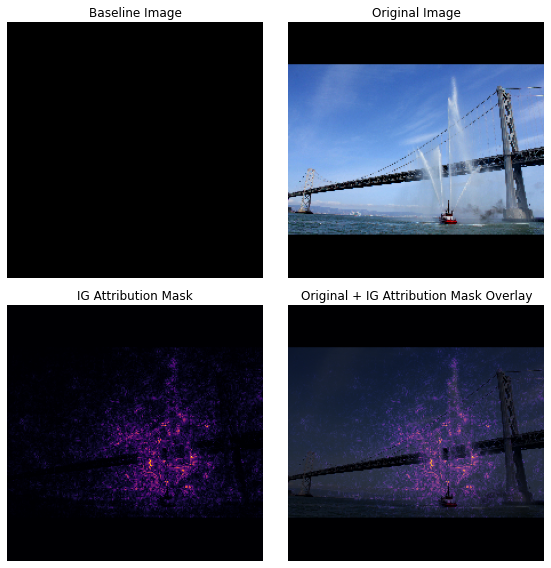

In [62]:
start = time.time()
image = img_tensors['Fireboat']
baseline = baseline_method(image, "Black")
_ = plot_img_attributions(model=inception_v1_classifier,
                          img=image,
                          baseline=baseline, 
                          target_class_idx=tf.constant(555), 
                          m_steps=tf.constant(2400),
                          cmap=plt.cm.inferno,
                          overlay_alpha=0.25)
end = time.time()
time_taken = end - start
print("Time to compute IG is %.2fs" % time_taken)

IG attributions on the "School Bus" image highlight the shape, front lighting, and front stop sign.

Time to compute IG is 5.17s


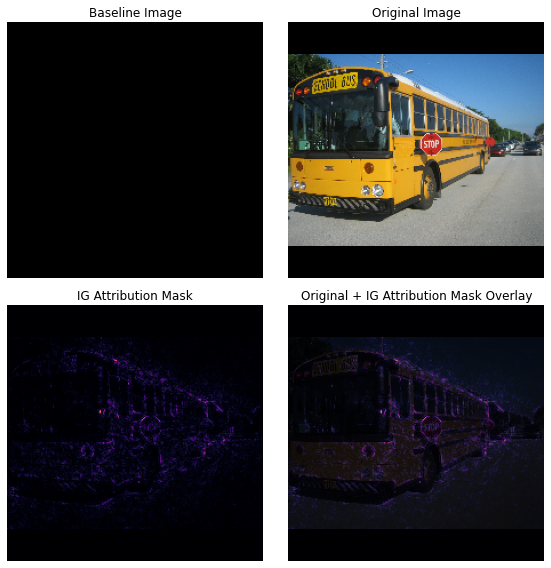

In [40]:
start = time.time()
image = img_tensors['School Bus']
baseline = baseline_method(image, "Black")
_ = plot_img_attributions(model=inception_v1_classifier,
                          img=image,
                          baseline=baseline, 
                          target_class_idx=tf.constant(555), 
                          m_steps=tf.constant(1200),
                          cmap=plt.cm.inferno,
                          overlay_alpha=0.1)
end = time.time()
time_taken = end - start
print("Time to compute IG is %.2fs" % time_taken)

IG attributions hightlight the texture, nose shape, and white fur of the Panda's face.

(-0.5, 223.5, 223.5, -0.5)

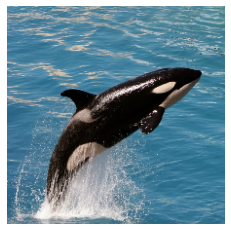

In [81]:
img = read_image("whale.jpg", preserve_aspect_ratio=False)
plt.imshow(img)
plt.axis("Off")

In [82]:
idx, _, _ = top_k_predictions(model=inception_v1_classifier,
                  img=img,
                  label_vocab=imagenet_labels,
                  top_k=1)
idx

<tf.Tensor: shape=(), dtype=int32, numpy=149>

In [83]:
alphas = tf.linspace(start=0.0, stop=1.0, num=51)
baseline = baseline_method(img, method="Blur", sigma=20)

path_inputs = interpolate_images(
    baseline=baseline,
    image=img,
    alphas=alphas)

path_gradients = compute_gradients(
    model=inception_v1_classifier,
    images=path_inputs,
    target_class_idx=idx)

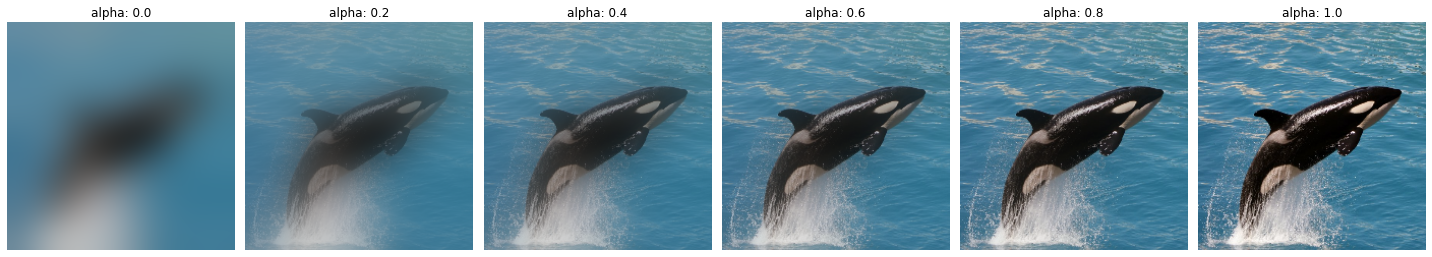

In [84]:
fig = plt.figure(figsize=(20, 20))

i = 0
for alpha, image in zip(alphas[0::10], path_inputs[0::10]):
  i += 1
  plt.subplot(1, len(alphas[0::10]), i)
  plt.title(f'alpha: {alpha:.1f}')
  plt.imshow(image)
  plt.axis('off')

plt.tight_layout();

(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


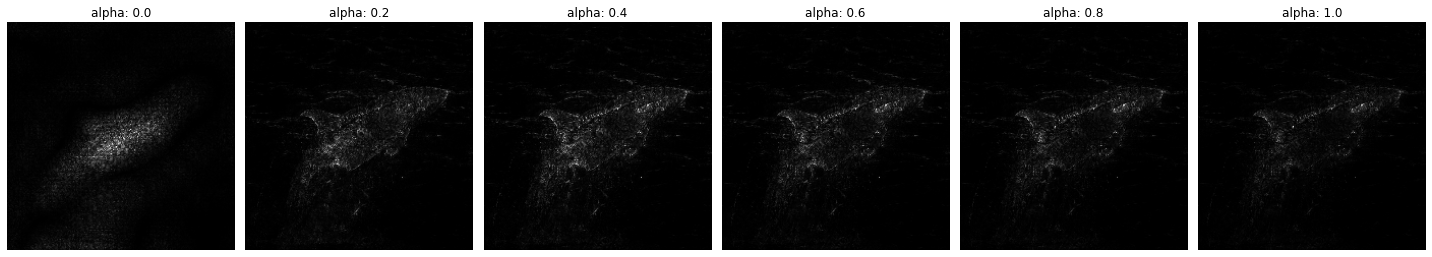

In [88]:
fig = plt.figure(figsize=(20, 20))
i = 0

for alpha, image in zip(alphas[0::10], path_inputs[0::10]):
  ig_attributions = integrated_gradients(model=inception_v1_classifier,
                                      baseline=baseline_method(image, method="Blur", sigma=20),
                                      input=image,
                                      target_class_idx=tf.constant(149),
                                      m_steps=tf.constant(1100),
                                      method='riemann_trapezoidal')
  print(ig_attributions.shape)
  attribution_mask = tf.reduce_sum(tf.math.abs(ig_attributions), axis=-1)

  i += 1
  plt.subplot(1, len(alphas[0::10]), i)
  plt.title(f'alpha: {alpha:.1f}')
  plt.imshow(attribution_mask, cmap=plt.cm.gray)
  plt.axis('off')
plt.tight_layout()

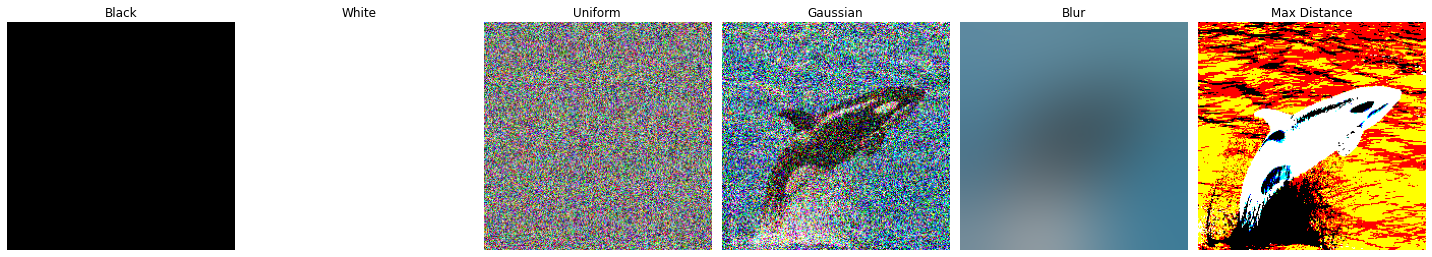

In [90]:
plt.figure(figsize=(20,20))
methods = ["Black", "White", "Uniform", "Gaussian", "Blur", "Max Distance"]
c = 1
for idx in methods:
  ax = plt.subplot(1, 6, c)
  ax.imshow(baseline_method(img, method=idx, sigma=0.5 if idx!="Blur" else 40))
  ax.set_title(idx)
  ax.axis('off')
  c += 1
plt.tight_layout()

(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


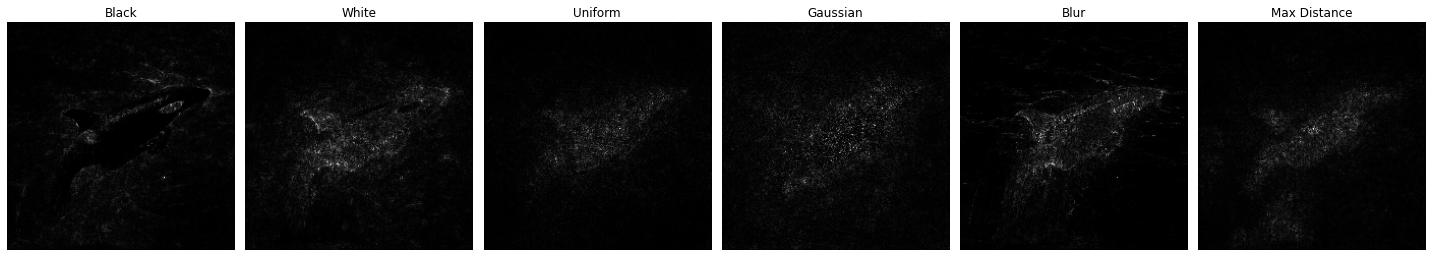

In [107]:
fig = plt.figure(figsize=(20, 20))
methods = ["Black", "White", "Uniform", "Gaussian", "Blur", "Max Distance"]
i = 0

for idx in methods:
  ig_attributions = integrated_gradients(model=inception_v1_classifier,
                                      baseline=baseline_method(img, method=idx, sigma=0.5 if idx!="Blur" else 30),
                                      input=img,
                                      target_class_idx=tf.constant(149),
                                      m_steps=tf.constant(1100),
                                      method='riemann_trapezoidal')
  
  print(ig_attributions.shape)
  attribution_mask = tf.reduce_sum(tf.math.abs(ig_attributions), axis=-1)

  i += 1
  plt.subplot(1, len(methods), i)
  plt.title(idx)
  plt.imshow(attribution_mask, cmap=plt.cm.gray)
  plt.axis('off')
plt.tight_layout()

1
2
3
4
5
6


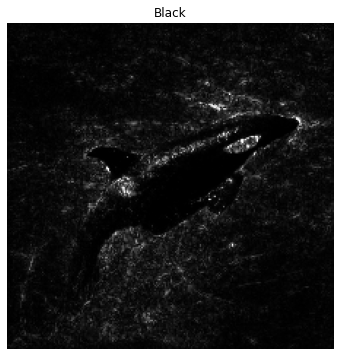

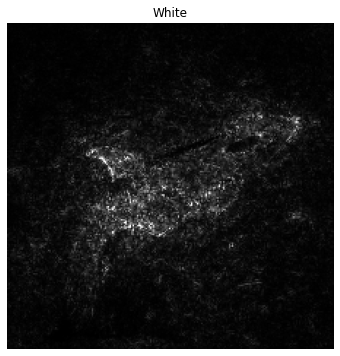

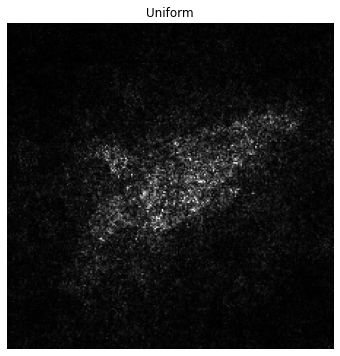

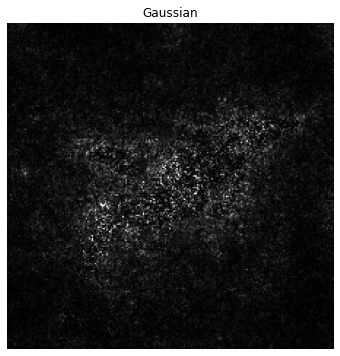

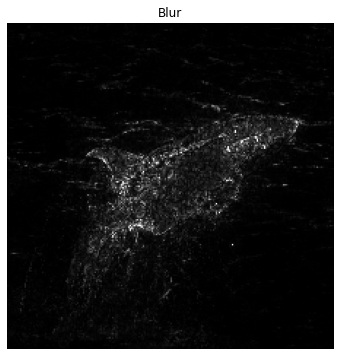

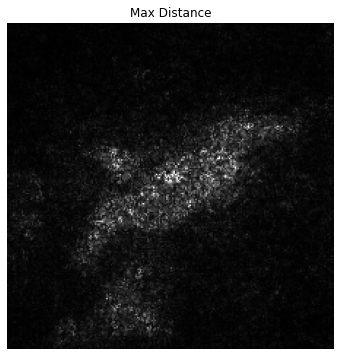

In [129]:
methods = ["Black", "White", "Uniform", "Gaussian", "Blur", "Max Distance"]
i = 0

for idx in methods:
  ig_attributions = integrated_gradients(model=inception_v1_classifier,
                                      baseline=baseline_method(img, method=idx, sigma=0.5 if idx!="Blur" else 30),
                                      input=img,
                                      target_class_idx=tf.constant(149),
                                      m_steps=tf.constant(1100),
                                      method='riemann_trapezoidal')
  
  attribution_mask = tf.reduce_sum(tf.math.abs(ig_attributions), axis=-1)

  i += 1
  print(i)
  plt.figure(figsize=(6, 6))
  plt.title(idx)
  plt.imshow(norm_clip(attribution_mask, percentile=99.95), cmap=plt.cm.gray)
  # plt.imshow(img, alpha=0.1)
  plt.axis('off')
  plt.savefig(idx + '.png', bbox_inches='tight')

In [127]:
def generate_gif(image_dir, anim_file):
	with imageio.get_writer(anim_file, mode='I') as writer:
		filenames = glob.glob(image_dir + '*.png')
		filenames = sorted(filenames)
		last = -1
		for i, filename in enumerate(filenames):
			frame = 10 * (i ** 0.5)
			if round(frame) > round(last):
				last = frame
			else:
				continue
			image = imageio.imread(filename)
			writer.append_data(image)
		image = imageio.imread(filename)
		writer.append_data(image)

In [128]:
anim_file = 'IG.gif'
image_dir = ""
generate_gif(image_dir, anim_file)

if IPython.version_info >= (6, 2, 0, ''):
	display.Image(filename=anim_file)

## Debugging Model Performance

IG feature attributions provide a useful debugging complement to dataset statistic and model performance evaluation metrics to better understand model quality. 

Using IG feature attributions for debugging gives following insights:


* Which features are important?
* How well does the model's learned features generalize?
* Does the model learn "incorrect" or spurious features in the image beyond the true class object?
* What features did my model miss?
* Comparing correct and incorrect examples of the same class, what is the difference in the feature attributions?

IG feature attributions are well suited for counterfactual reasoning to gain insight into model's performance and limitations. This involves comparing feature attributions for images of the same class that receive different predictions. When combined with model performance metrics and dataset statistics, IG feature attributions give greater insight into model errors during debugging to understand which features contributed to the incorrect prediction when compared to feature attributions on correct predictions.

In the example below, 3 transformations are applied to the "Yellow Labrador Retriever" image and constrast correct and incorrect IG feature attributions to gain insight into your model's limitations.

In [ ]:
img = read_image("YellowLabrador.jpg", preserve_aspect_ratio=False)
plt.imshow(img)

In [ ]:
rotate90_labrador_retriever_img = tf.image.rot90(img)
upsidedown_labrador_retriever_img = tf.image.flip_up_down(img)
zoom_labrador_retriever_img = tf.keras.preprocessing.image.random_zoom(x=img, zoom_range=(0.45,0.45))

In [ ]:
_ = plot_img_predictions(
    model=inception_v1_classifier,
    img=tf.stack([img,
                  rotate90_labrador_retriever_img, 
                  upsidedown_labrador_retriever_img,
                  zoom_labrador_retriever_img]),
    img_titles=tf.stack(['Yellow Labrador Retriever (original)',
                         'Yellow Labrador Retriever (rotated 90 degrees)',
                         'Yellow Labrador Retriever (flipped upsidedown)',
                         'Yellow Labrador Retriever (zoomed in)']),
    label_vocab=imagenet_labels, 
    top_k=5
    )

In [ ]:
def generate_figures(model,
                     img, 
                     img_titles,
                     m_steps=1100, 
                     top_k=3,
                     percentile=99.9):

  pred_idx, pred_label, pred_proba = top_k_predictions(model=model, 
                                                       img=img, 
                                                       label_vocab=label_vocab, 
                                                       top_k=top_k)
  
  
  pred_idx_arr = pred_idx.numpy()
  pred_label_arr = pred_label.numpy()
  pred_proba_arr = pred_proba.numpy()
  n_rows = 1
  n_cols = 4

  fig = plt.figure(figsize=(12, 20))

  # Plot Original Input Image
  plt.subplot(n_rows, n_cols, 1)
  plt.imshow(image)
  plt.axis('off')
  plt.title("Original Image")

  # Display top-K label and score
  plt.subplot(n_rows, n_cols, 2)
  plt.axis('off')
  if idx==0:
    plt.title("Top {:} Label and Score".format(top_k))
  for k in range(top_k):
    k_idx = pred_idx_arr[idx, k]
    k_label = pred_label_arr[idx, k].decode('utf-8')
    k_proba = pred_proba_arr[idx, k]
    if k==0:
      s = '{:}: ({:}-{:}) Score: {:.1%}'.format(k+1, k_idx, k_label, k_proba)
      plt.text(0.1, 0.6, s, fontsize=5, fontweight='bold')
    else:
      s = '{:}: ({:}-{:}) Score: {:.1%}'.format(k+1, k_idx, k_label, k_proba)
      plt.text(0.1, 0.6-0.1*k, s, fontsize=5)
  plt.axis("off")

  plt.tight_layout()      

  return fig

These rotation and zooming examples serve to highlight an important limitation of convolutional neural networks like Inception V1 - CNNs are not naturally rotationally or scale invariant. All of these examples resulted in incorrect predictions. Comparing 2 example attributions - one incorrect prediction vs. one known correct prediction - gives a deeper feature-level insight into why the model made an error to take corrective action.

In [ ]:
baseline = baseline_method(img, "Black")
labrador_retriever_attributions = integrated_gradients(model=inception_v1_classifier,
                          baseline=baseline,  
                          input=img,
                          target_class_idx=tf.constant(209),
                          m_steps=tf.constant(1250),
                          method='riemann_trapezoidal')

image = zoom_labrador_retriever_img
baseline = baseline_method(image, "Black")

zoom_labrador_retriever_attributions = integrated_gradients(model=inception_v1_classifier,
                          baseline=baseline,
                          input=image,
                          target_class_idx=tf.constant(209),
                          m_steps=tf.constant(1250),
                          method='riemann_trapezoidal')

Zooming in on the Labrador Retriever image causes Inception V1 to incorrectly predict a different dog breed, a Saluki. By comparing the IG attributions on the incorrect and correct predictions, one can see the IG attributions on the zoomed image still focus on the legs but they are now much further apart and the midsection is proportionally narrower. Compared to the IG attributions on the original image, the visible head size is significantly smaller as well. Aimed with deeper feature-level understanding of model's error, the model performance can be improved by pursuing strategies such as training data augmentation to make model more robust to changes in object proportions or to check that the image preprocessing code is the same during training and serving in order to prevent data skew introduced from by zooming or resizing operations.

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=3, squeeze=False, figsize=(16, 12))

axs[0,0].set_title('IG Attributions - Incorrect Prediction: Saluki')
axs[0,0].imshow(normalize(tf.reduce_sum(tf.abs(zoom_labrador_retriever_attributions), axis=-1)) , cmap=plt.cm.inferno)
axs[0,0].axis('off')

axs[0,1].set_title('IG Attributions - Correct Prediction: Labrador Retriever')
axs[0,1].imshow(normalize(tf.reduce_sum(tf.abs(labrador_retriever_attributions), axis=-1)), cmap=plt.cm.hot)
axs[0,1].axis('off')

axs[0,2].set_title('IG Attributions - both predictions overlayed')
axs[0,2].imshow(normalize(tf.reduce_sum(tf.abs(zoom_labrador_retriever_attributions), axis=-1)), cmap=plt.cm.inferno, alpha=1.0)
axs[0,2].imshow(normalize(tf.reduce_sum(tf.abs(labrador_retriever_attributions), axis=-1)), cmap=plt.cm.hot, alpha=0.6)
axs[0,2].axis('off')

plt.tight_layout();

## Properties


To summarize, IG is a popular Explainable AI method because of its broad applicability to any differentiable model, ease of implementation as this notebook demonstrated, and relative computational efficiency compared to alternative explainability approaches that allows it to scale to large networks and feature spaces (e.g. images).

Explainable AI techniques are challenging to empirically evaluate and compare against each other. A secondary contribution of the original IG paper was to establish several axioms to evaluate explainability approaches and guide their own development of IG. Below are the axioms restated for clarity:

* Completeness: the sum of IG attributions of all features is equal to the 
difference in your model's output for its input features and your model's output for the basline. The implications of this property are that one has a theoretical basis to determine how well IG's integral approximation converged and how should the number of steps hyperparameter be adjusted. 

* Sensitivity: all input features that differ between the input and baseline and result in different predictions leads to a non-zero attribution by IG. Conversely, any feature that does not impact the model's function will not receive any attribution. The practical implication of sensitivity is that one can count on IG to identify all feature importances and be more resistant to spurious attributions compared to just gradients. The key is in proper selection of the baseline.

* Implementation Invariance: IG attributions will be the same for functionally equivalent models that output the same value for any given input. This is important to note in practice when interpretting and communicating results, because models with vastly different architectures and hyperparameters, can have identical IG attributions.

* Linearity: Gradients are a natural analog to coefficients in linear models. IG attributions preserve linear relationships in the model. This includes linear combinations of different models; for these combined ensembled models, attributions represented the weighted sum between the individual model's attributions.

## Limitations

* **IG provides local, not global interpretability:** IG provides a theoretically sound understanding of feature importances on individual examples. However, it does not provide a relative global feature importance for understanding overall model performance across data sets. For image data, there is no clear way to aggregate feature attributions of individual image pixels for global model interpretability. Individual pixels by themselves carry little meaning; its through their combination with other pixels into higher order features (e.g. edges, shapes) can determine meaning. Although it is importance to keep in mind interpretation of these results can be potentially misleading and sensitive to feature baseline selection and relationships between features.

*  **IG explains network predictions in relation to individual features, not feature interactions and combinations:** Deep Neural Networks are powerful universal function approximators due to flexible function fitting capabilities that non-linearities (e.g. activation functions) introduce. However, IG is doing a first-order linear approximation of the functional relationship between model outputs and individual input features so we still do not know how the individual features interact, which are correlated, and how the network combines features to make its prediction.

* **IG can only be applied to differentiable ML models:** IG can be applied to any differentiable models such as neural networks. However, this method cannot be applied to other types of ML models without modification such as tree-based models or model ensembles that involve non-differentiable parts.

* **Limitations of baseline selection and visual inspection:** The proper interpretation of IG feature attributions depends upon selection of a good baseline. A black image is a great choice in most scenarios to limit interpretation of the prediction to the input features without any artifacts from the baseline but is limited when pixels important to the prediction are black themselves. As a result, visual inspection of the IG prediction attributions does not by itself always highlight all pixels of importance and may require trying out a few different baselines and contrastive explanations to fully understand the model's learned representation.

## Experiments

In [ ]:
def image_gradient(model, image, target_class_idx):
  images = tf.expand_dims(image, 0)
  grad = compute_gradients(model=inception_v1_classifier,
                      images=images,
                      target_class_idx=555)
  img_grad = images*grad
  img_grad = tf.reduce_sum(tf.math.abs(img_grad), axis=-1)

  return img_grad

In [ ]:
BATCH_SIZE = 6
img_test = make_dataset("test.tfrecord").batch(BATCH_SIZE)

In [ ]:
def generate_figures(model, img, label_vocab, 
                     base_method="Black", 
                     m_steps=1100, 
                     method='riemann_trapezoidal',
                     cmap=plt.cm.inferno,
                     overlay_alpha=0.2,
                     top_k=3,
                     percentile=99.9):

  pred_idx, pred_label, pred_proba = top_k_predictions(model=model, 
                                                       img=img, 
                                                       label_vocab=label_vocab, 
                                                       top_k=top_k)
  
  
  pred_idx_arr = pred_idx.numpy()
  pred_label_arr = pred_label.numpy()
  pred_proba_arr = pred_proba.numpy()
  n_rows = img.shape[0]+1
  n_cols = 3

  fig = plt.figure(figsize=(10, 25))
  
  # Plot baseline Input
  baseline=baseline_method(img[0], base_method)
  plt.subplot(n_rows, n_cols, 2)
  plt.imshow(baseline)
  plt.axis('off')
  plt.title("Baseline")

  for idx, image in enumerate(img):
    # Plot Original Input Image
    plt.subplot(n_rows, n_cols, n_cols*idx+4)
    plt.imshow(image)
    plt.axis('off')
    if idx==0:
      plt.title("Original Image")
    
    # # Display top-K label and score
    # plt.subplot(n_rows, n_cols, n_cols*idx+3)
    # plt.axis('off')
    # if idx==0:
    #   plt.title("Top {:} Label and Score".format(top_k))
    # for k in range(top_k):
    #   k_idx = pred_idx_arr[idx, k]
    #   k_label = pred_label_arr[idx, k].decode('utf-8')
    #   k_proba = pred_proba_arr[idx, k]
    #   if k==0:
    #     s = '{:}: ({:}-{:}) Score: {:.1%}'.format(k+1, k_idx, k_label, k_proba)
    #     plt.text(0.1, 0.6, s, fontsize=5, fontweight='bold')
    #   else:
    #     s = '{:}: ({:}-{:}) Score: {:.1%}'.format(k+1, k_idx, k_label, k_proba)
    #     plt.text(0.1, 0.6-0.1*k, s, fontsize=5)
    # plt.axis("off")

    # Plot gradients at image
    img_grad = image_gradient(
        model=model, 
        image=image, 
        target_class_idx=pred_idx_arr[idx, 0])
  
    plt.subplot(n_rows, n_cols, n_cols*idx+5)
    plt.imshow(tf.squeeze(img_grad), cmap=cmap)
    plt.imshow(normalize(image), alpha=overlay_alpha)
    plt.axis('off')
    if idx==0:
      plt.title("Gradients at Image")

    # Plot Integrated Gradients
    ig_attributions = integrated_gradients(
        model=model,
        baseline=baseline,
        input=image,
        target_class_idx=pred_idx_arr[idx, 0],
        m_steps=m_steps,
        method=method
    )
    attribution_mask = tf.reduce_sum(tf.math.abs(ig_attributions), axis=-1)
    
    ## Checking convergence for completeness
    convergence_check(
        model=model,
        attributions=ig_attributions, 
        baseline=baseline,
        input=image, 
        target_class_idx=pred_idx_arr[idx, 0]
    )
    plt.subplot(n_rows, n_cols, n_cols*idx+6)
    plt.imshow(norm_clip(attribution_mask, percentile), cmap=cmap)
    plt.imshow(normalize(image), alpha=overlay_alpha)
    plt.axis('off')
    if idx==0:
      plt.title("Integrated Gradients")

  plt.tight_layout()      

  return fig

In [ ]:
for img in img_test:
  generate_figures(
      model=inception_v1_classifier,
      img=img,
      label_vocab=imagenet_labels,
      m_steps=2200,
      cmap=plt.cm.gray,
      percentile=99.99,
      overlay_alpha=0.05
  )

In [ ]:
def baseline_comparison(image, 
                        model=inception_v1_classifier,
                        label_vocab=imagenet_labels, 
                        m_steps=1100, 
                        method='riemann_trapezoidal',
                        cmap=plt.cm.inferno,
                        overlay_alpha=0.2,
                        percentile=99.9,
                        sigma=0.5):

  pred_idx, pred_label, pred_proba = top_k_predictions(model=model, 
                                                       img=image, 
                                                       label_vocab=label_vocab, 
                                                       top_k=1)
  
  methods = ["Black", "White", "Uniform", "Gaussian", "Blur", "Max Distance"]
  pred_idx_arr = pred_idx.numpy()
  pred_label_arr = pred_label.numpy()
  pred_proba_arr = pred_proba.numpy()
  n_rows = len(methods)+1
  n_cols = 3

  fig = plt.figure(figsize=(8, 18))
  
  # Plot Original Input Image
  plt.subplot(n_rows, n_cols, 2)
  plt.imshow(image)
  plt.axis('off')
  plt.title("Original Image")

  for idx, bs_method in enumerate(methods):

    # Plot baseline Input
    baseline=baseline_method(image, method=bs_method, sigma=sigma)
    if bs_method=="Blur":
      baseline=baseline_method(image, method=bs_method, sigma=10*sigma)
    plt.subplot(n_rows, n_cols, n_cols*idx+4)
    plt.imshow(baseline)
    plt.axis('off')
    plt.title("Baseline: " + bs_method)


    # Plot Integrated Gradients
    ig_attributions = integrated_gradients(
        model=model,
        baseline=baseline,
        input=image,
        target_class_idx=pred_idx_arr,
        m_steps=m_steps,
        method=method
    )
    attribution_mask = tf.reduce_sum(tf.math.abs(ig_attributions), axis=-1)
    
    plt.subplot(n_rows, n_cols, n_cols*idx+5)
    plt.imshow(norm_clip(attribution_mask, percentile), cmap=cmap)
    plt.axis('off')
    if idx==0:
      plt.title("IG Mask")
    
    ## Checking convergence for completeness
    convergence_check(
        model=model,
        attributions=ig_attributions, 
        baseline=baseline,
        input=image, 
        target_class_idx=pred_idx_arr
    )

    plt.subplot(n_rows, n_cols, n_cols*idx+6)
    plt.imshow(norm_clip(attribution_mask, percentile), cmap=cmap)
    plt.imshow(normalize(image), alpha=overlay_alpha)
    plt.axis('off')
    if idx==0:
      plt.title("Integrated Gradients")

  plt.tight_layout()      

  return fig

In [ ]:
_ = baseline_comparison(
      image=read_image("whale.jpg"),
      m_steps=4000,
      cmap=plt.cm.gray,
      overlay_alpha=0.4)

In [ ]:
_ = baseline_comparison(
      image=read_image("Pencil.jpg"),
      m_steps=6000,
      cmap=plt.cm.gray,
      overlay_alpha=0.4)

In [ ]:
def blur_baseline(model, img, label_vocab, 
                     m_steps=1100, 
                     method='riemann_trapezoidal',
                     cmap=plt.cm.inferno,
                     overlay_alpha=0.2,
                     top_k=3,
                     percentile=99.9):

  pred_idx, pred_label, pred_proba = top_k_predictions(model=model, 
                                                       img=img, 
                                                       label_vocab=label_vocab, 
                                                       top_k=top_k)
  
  
  pred_idx_arr = pred_idx.numpy()
  pred_label_arr = pred_label.numpy()
  pred_proba_arr = pred_proba.numpy()
  n_rows = img.shape[0]+1
  n_cols = 4

  fig = plt.figure(figsize=(12, 18))
  

  for idx, image in enumerate(img):
    # Plot baseline Input
    baseline=baseline_method(image, "Blur", sigma=20.0)
    plt.subplot(n_rows, n_cols, n_cols*idx+1)
    plt.imshow(baseline)
    plt.axis('off')
    if idx==0:
      plt.title("Blur Baseline")

    # Plot Original Input Image
    plt.subplot(n_rows, n_cols, n_cols*idx+2)
    plt.imshow(image)
    plt.axis('off')
    if idx==0:
      plt.title("Original Image")

    # Plot gradients at image
    img_grad = image_gradient(
        model=model, 
        image=image, 
        target_class_idx=pred_idx_arr[idx, 0])
  
    plt.subplot(n_rows, n_cols, n_cols*idx+3)
    plt.imshow(tf.squeeze(img_grad), cmap=cmap)
    plt.imshow(normalize(image), alpha=overlay_alpha)
    plt.axis('off')
    if idx==0:
      plt.title("Gradients at Image")

    # Plot Integrated Gradients
    ig_attributions = integrated_gradients(
        model=model,
        baseline=baseline,
        input=image,
        target_class_idx=pred_idx_arr[idx, 0],
        m_steps=m_steps,
        method=method
    )
    attribution_mask = tf.reduce_sum(tf.math.abs(ig_attributions), axis=-1)
    
    ## Checking convergence for completeness
    convergence_check(
        model=model,
        attributions=ig_attributions, 
        baseline=baseline,
        input=image, 
        target_class_idx=pred_idx_arr[idx, 0]
    )
    plt.subplot(n_rows, n_cols, n_cols*idx+4)
    plt.imshow(norm_clip(attribution_mask, percentile), cmap=cmap)
    plt.imshow(normalize(image), alpha=overlay_alpha)
    plt.axis('off')
    if idx==0:
      plt.title("Integrated Gradients")

  plt.tight_layout()      

  return fig

In [ ]:
for img in img_test:
  blur_baseline(
      model=inception_v1_classifier,
      img=img,
      label_vocab=imagenet_labels,
      m_steps=1100,
      cmap=plt.cm.gray,
      percentile=99.98,
      overlay_alpha=0.1
  )